In [1]:
import tokenizers # Step 1 : 문장 토큰화
import gensim # Step 2 : 토큰→숫자(벡터) 임베딩
import numpy as np #수치연산
import pandas as pd #데이터전처리

- KT, SKT, LGU+ 관련 댓글 여론 파악
- 각 기사 별로 (각 시기에 따라) 기업 별 여론이 어떤지 '측정'
- 개별 댓글마다 **얼마나 공격적인/부정적인 댓글인지** 측정해야 함
- 머신러닝 기반의 기업 뉴스 긍부정 분류기 개발
    - 토큰화
    - 임베딩
    - 분류기

### 1-1. 데이터셋 준비

In [2]:
np.random.seed(0) #난수(random number) 고정

jobplanetdf = pd.read_csv('./data/jobplanet_review.csv', index_col=0)
moviedf = pd.read_csv('./data/naver_movie.csv', index_col=0).sample(350)
shoppingdf = pd.read_csv('./data/naver_shopping.csv', index_col=0).sample(350)
enterdf = pd.read_csv('./data/beep_dataset.csv', index_col=0).sample(350)
moviedf.columns = ['text', 'label']
shoppingdf.columns = ['text', 'label']
enterdf.columns = ['text', 'label']

In [3]:
textdf =\
pd.concat([moviedf, shoppingdf, enterdf,
           jobplanetdf[jobplanetdf['label']==1][['good', 'label']].rename({'good':'text'}, axis=1),
           jobplanetdf[jobplanetdf['label']==0][['bad', 'label']].rename({'bad':'text'}, axis=1)], axis=0, ignore_index=True)

textdf 레이블은....
- 긍정은 1
- 부정은 0

In [25]:
negative_words = ['나쁜', '구린', '최악', '별로', '못된', '박봉', '낭비', '억압', '수직', '유치', '불필요', '꼰대', '정치질', '지루', '노잼']
textdf['pred'] =\
np.where(textdf['text'].str.contains('|'.join(negative_words)), 0, 1)
textdf['iscorrect'] = np.where(textdf['label']==textdf['pred'], 1, 0)
np.mean(textdf['iscorrect'])

0.5644500472738733

In [36]:
welfaredf = pd.read_csv('./data/welfare_news.csv', index_col=0)
mobiledf = pd.read_csv('./data/mobilecarrier_news.csv', index_col=0)

In [50]:
corpus =\
pd.concat([textdf['text'], welfaredf['title'], welfaredf['content'], mobiledf['title'].drop_duplicates()], ignore_index=True)
corpus = corpus.str.replace('\[(.*?)\]', '') #정규표현식
corpus = corpus.str.split().str.join(' ') #중복 띄어쓰기 제거

In [61]:
# 첫 번째 학습
from tokenizers import SentencePieceBPETokenizer
bpe_tokenizer = SentencePieceBPETokenizer()
bpe_tokenizer.train_from_iterator(corpus)

In [77]:
token_corpus = []
for sent in tqdm(corpus) :
    output = bpe_tokenizer.encode(sent).tokens
    token_corpus.append(output)
token_corpus = pd.Series(token_corpus)

100%|███████████████████████████████████████████████████████████████████████████| 15138/15138 [00:16<00:00, 899.52it/s]


In [78]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec, FastText

w2v_model = Word2Vec(token_corpus, sg=1, epochs=7)
ft_model = FastText(token_corpus, sg=1, epochs=7)

### 4. 단어-벡터 임베딩(Tokenization)

In [18]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec, FastText

w2v_model = Word2Vec(token_corpus, sg=1, epochs=7)
ft_model = FastText(token_corpus, sg=1, epochs=7)

w2v_model.save('./model/word2vec.model')
ft_model.save('./model/fasttext.model')

In [19]:
w2v_model = Word2Vec.load('./model/word2vec.model')
ft_model = FastText.load('./model/fasttext.model')

In [20]:
w2v_model.wv['연봉']

array([-6.98279560e-01,  3.41737062e-01,  4.81373429e-01,  3.54369789e-01,
       -2.79701859e-01,  1.10048808e-01, -1.22517772e-01, -5.21665497e-04,
        1.12048402e-01,  1.17490590e-01, -1.56347454e-01, -6.73366129e-01,
       -3.80719360e-03,  3.58526319e-01, -1.47793680e-01,  6.98661357e-02,
       -1.11944415e-02,  3.43430080e-02,  2.76096612e-01,  1.71718538e-01,
       -2.39261791e-01,  7.06743121e-01, -2.96038598e-01,  1.93332553e-01,
        2.76378971e-02, -2.52391368e-01, -1.96680278e-01,  3.61599505e-01,
       -2.63215840e-01, -3.40067118e-01,  1.65190861e-01,  1.17417775e-01,
       -1.76941484e-01,  3.36162060e-01, -3.97318453e-01, -3.13215256e-01,
        3.53982449e-01, -2.79376924e-01,  2.68941730e-01,  2.26636097e-01,
        2.97791541e-01,  2.77890172e-02, -8.18398148e-02, -1.17654547e-01,
       -1.14365876e-01,  1.55705705e-01,  4.62470949e-02, -5.12289286e-01,
        6.46722270e-03, -1.27233341e-01, -1.40132651e-01,  3.88348498e-03,
        1.42480075e-01, -

In [21]:
w2v_model.wv['고인물']

KeyError: "Key '고인물' not present"

In [22]:
ft_model.wv['고인물']

array([-0.09940056, -0.03564939,  0.09870532,  0.02966512, -0.01790801,
       -0.01233355, -0.00055947,  0.09083677, -0.05760286, -0.0041881 ,
        0.02426949, -0.13433151,  0.00862485,  0.10676658, -0.12296668,
        0.04470526,  0.06632576, -0.01397197,  0.01218883, -0.05793754,
       -0.1553409 ,  0.14258975, -0.05602446, -0.02750884,  0.00367039,
       -0.00680569, -0.04691146,  0.12103314,  0.00774853, -0.00323641,
        0.0120238 , -0.08482864, -0.0089274 ,  0.05476988, -0.06147758,
       -0.05811347, -0.10383523, -0.00151175,  0.04954945,  0.05613916,
       -0.02653487,  0.02346732, -0.01719736,  0.10358842,  0.02268302,
        0.04163911, -0.06888217, -0.15899532, -0.04606161,  0.00088532,
       -0.06294958,  0.05990667,  0.01108983,  0.01025069, -0.01414967,
       -0.07395557,  0.0735611 ,  0.00243848,  0.04878221,  0.12280196,
        0.00050942, -0.00198849, -0.07220486,  0.08857828,  0.00114007,
       -0.03337764,  0.04306204,  0.03597564, -0.073215  ,  0.10

In [30]:
ft_model.wv.most_similar('데이터')

[('빅데이터', 0.9183898568153381),
 ('▁빅데이터', 0.87186199426651),
 ('▁데이터베이스', 0.8555660843849182),
 ('중앙화', 0.8530203104019165),
 ('▁데이터센터', 0.8470616936683655),
 ('▁DLP', 0.8467522263526917),
 ('▁보안관제', 0.8399450778961182),
 ('위협', 0.835642397403717),
 ('접근', 0.8345462679862976),
 ('▁데이터', 0.832171618938446)]

In [31]:
ft_model.wv.most_similar('보상')

[('징수', 0.8502567410469055),
 ('계약서', 0.8480408787727356),
 ('여금', 0.8358345031738281),
 ('유지', 0.8314090371131897),
 ('보험의', 0.8235677480697632),
 ('청구', 0.8230589628219604),
 ('▁산업재해보상', 0.8089543581008911),
 ('▁살생물', 0.808185875415802),
 ('개선', 0.8065752983093262),
 ('▁징수', 0.7960982918739319)]

In [37]:
ft_model.wv.similarity('계약직', '비정규직')

0.77200586

In [38]:
ft_model.wv.similarity('보상', '청구')

0.8230589

In [39]:
ft_model.wv.similarity('보상', '계약직')

0.5089019

In [40]:
ft_model.wv.similarity('보상', '할리우드')

0.28621542

### 5. 문장 분류 (Document Classification)

In [107]:
tokens = bpe_tokenizer.encode('이 회사는연봉상승이 너무 짜다').tokens
embedding = np.mean([ft_model.wv[tk] for tk in tokens], axis=0)
embedding.shape

(100,)

In [113]:
def text_to_embedding(input_sent) :
    tokens = bpe_tokenizer.encode(input_sent).tokens
    embedding = np.mean([ft_model.wv[tk] for tk in tokens], axis=0)
    return embedding

In [118]:
embedding_list = []
for sent in textdf['text'] :
    embedding_list.append(text_to_embedding(sent))
textdf['embedding'] = embedding_list

In [125]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

In [121]:
np.random.seed(0)
X_train, X_test, y_train, y_test =\
train_test_split(np.vstack(textdf['embedding'].values), textdf['label'].values, test_size=.25, random_state=0)

In [122]:
# Logistic Regression
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)

# Support Vector Machine
svm_clf = svm.SVC()
svm_clf.fit(X_train, y_train)

# Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=0)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(oob_score=True, random_state=0)

In [126]:
accuracy_score(y_test, lr_clf.predict(X_test)), f1_score(y_test, lr_clf.predict(X_test))

(0.7770780856423174, 0.7806691449814127)

In [127]:
accuracy_score(y_test, svm_clf.predict(X_test)), f1_score(y_test, svm_clf.predict(X_test))

(0.7997481108312342, 0.7979669631512071)

In [128]:
accuracy_score(y_test, rf_clf.predict(X_test)), f1_score(y_test, rf_clf.predict(X_test))

(0.7556675062972292, 0.7610837438423645)

In [129]:
def company_sentiment_classifier(input_sent) :
    embedding = text_to_embedding(input_sent)
    output = svm_clf.predict(embedding.reshape(1,-1))[0]
    return output    

In [142]:
mobiledf = mobiledf[mobiledf['comment'].str.split().str.join(' ').str.len()>3].reset_index(drop=True)

In [143]:
akpul_list = []
for comment in tqdm(mobiledf['comment']) :
    akpul_list.append(company_sentiment_classifier(comment))
mobiledf['sentiment'] = akpul_list    

100%|███████████████████████████████████████████████████████████████████████████| 34025/34025 [00:38<00:00, 880.29it/s]


In [154]:
skdf = mobiledf[mobiledf['title'].str.contains('SK|sk|텔레콤|skt|SKT')].reset_index(drop=True)
sentimentdf = skdf.groupby('month', as_index=False).mean()

In [162]:
sentimentdf

,month,sentiment
0,202102,0.000000
1,202104,0.167095
2,202105,0.185430
3,202106,0.188742
4,202107,0.099531
5,202108,0.175000
6,202109,0.158654
7,202110,0.138643
8,202111,0.145455
9,202112,0.000000


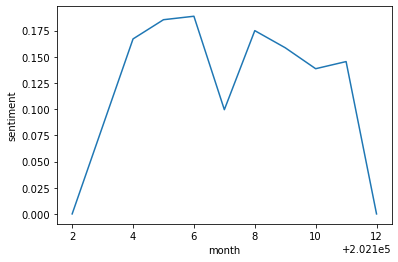

In [158]:
import seaborn as sns
sns.lineplot(x='month', y='sentiment', data=sentimentdf)

In [134]:
company_sentiment_classifier('속도 장난질이 말이 되냐')

0

In [133]:
company_sentiment_classifier('SK가 더 좋은 듯')

1

In [51]:
hr_sentiment_classifier('자유분방하고 수평적인 분위기')

1

In [52]:
hr_sentiment_classifier('연봉이 거의 안 오름')

0

In [53]:
hr_sentiment_classifier('초봉이 높아서 만족')

0

In [54]:
hr_sentiment_classifier('적어도 내가 속한 팀은 꼰대 쌉쓰레기임')

0

In [55]:
hr_sentiment_classifier('KT는 배상하라 배상하라')

0

In [56]:
hr_sentiment_classifier('믿음직한 회사 LG U+')

1

In [57]:
hr_sentiment_classifier('믿고 쓰는 SKT')

1